### Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# BUILT-IN
import os
import csv
import glob
import uuid
import h5py
import time
import random
import warnings
import numpy as np
from scipy.signal import butter, sosfiltfilt, resample, get_window
from scipy.signal import welch as scipy_welch
from scipy.signal.windows import tukey
from scipy.stats import beta
from scipy.stats import halfnorm

# PyCBC
import pycbc
from pycbc import DYN_RANGE_FAC
from pycbc.filter import highpass as pycbc_highpass
from pycbc.psd import inverse_spectrum_truncation, welch, interpolate
from pycbc.types import TimeSeries, FrequencySeries

# LALSimulation Packages
import lalsimulation as lalsim

# Using segments to read O3a noise
import requests
import ligo.segments

import matplotlib.pyplot as plt

/home/nnarenraju/Research/ORChiD/DEBUGGING/ML-GWSC1-Glasgow/source/baseline/.venv/lib64/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [3]:
from pycbc import transforms
from pycbc.filter.matchedfilter import sigmasq
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.psd import inverse_spectrum_truncation, interpolate

import pycbc.waveform, pycbc.noise, pycbc.psd, pycbc.detector
from pycbc import distributions

In [4]:
from tqdm import tqdm
import math
import itertools

In [5]:
import multiprocessing

In [6]:
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})

### Generating uniform mass samples

In [7]:
num_samples = 10_000_000
_mass1 = np.random.uniform(7.0, 50.0, num_samples)
_mass2 = np.random.uniform(7.0, 50.0, num_samples)
foo = np.column_stack((_mass1, _mass2))
foo.sort(axis=1)
mass1 = foo[:,1]
mass2 = foo[:,0]

In [8]:
q = mass1/mass2
mchirp = (mass1*mass2)**(3./5.) / (mass1+mass2)**(1./5.)
M = mass1 + mass2

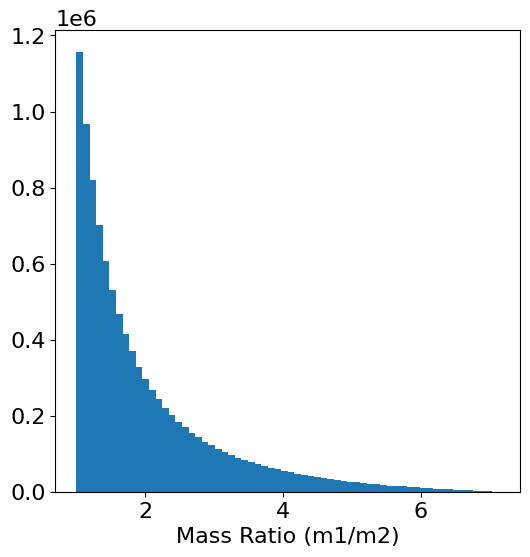

In [9]:
plt.figure(figsize=(6.0, 6.0))
plt.hist(q, bins=64)
plt.xlabel('Mass Ratio (m1/m2)')
plt.show()

In [14]:
1.0 - len(q[q>2.0])/len(q)

0.6494111

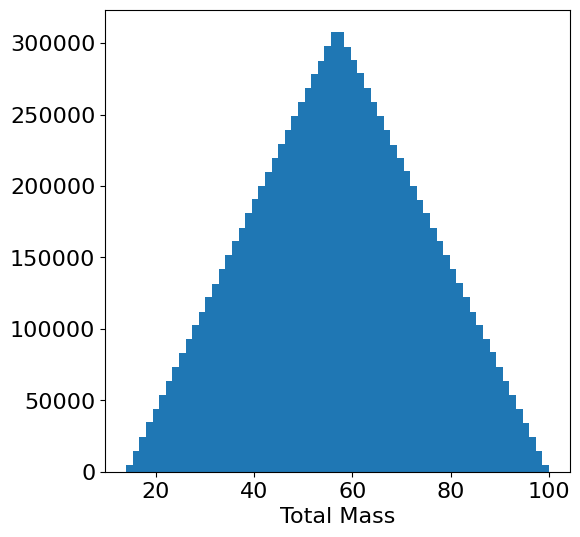

In [11]:
plt.figure(figsize=(6.0, 6.0))
plt.hist(M, bins=64)
plt.xlabel('Total Mass')
plt.show()

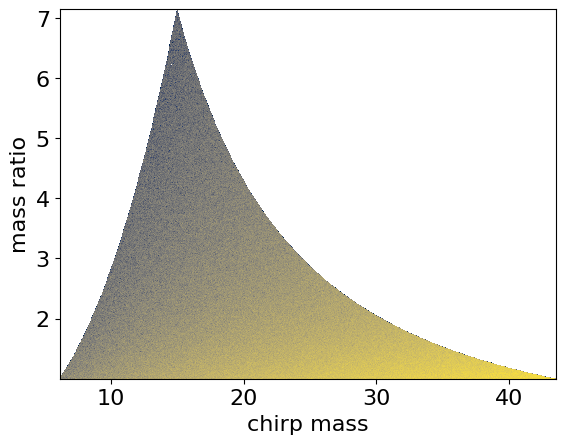

In [17]:
# Relationship between chirp mass and mass ratio
plt.hist2d(mchirp, q, cmap='cividis', bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('chirp mass')
plt.ylabel('mass ratio')
plt.show()

In [18]:
def mass1_from_mchirp_q(mchirp, q):
    """Returns the primary mass from the given chirp mass and mass ratio."""
    mass1 = q**(2./5.) * (1.0 + q)**(1./5.) * mchirp
    return mass1

def mass2_from_mchirp_q(mchirp, q):
    """Returns the secondary mass from the given chirp mass and mass ratio."""
    mass2 = q**(-3./5.) * (1.0 + q)**(1./5.) * mchirp
    return mass2

In [19]:
# Limits on chirp mass
ml = 7.0 # Msun
mu = 50.0 # Msun
min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)

mc = np.random.uniform(min_mchirp, max_mchirp, 100_000)
q = np.random.uniform(1.0, mu/ml, 100_000)

In [21]:
m1 = [mass1_from_mchirp_q(_mc, _q) for _mc, _q in zip(mc, q)]
m2 = [mass2_from_mchirp_q(_mc, _q) for _mc, _q in zip(mc, q)]

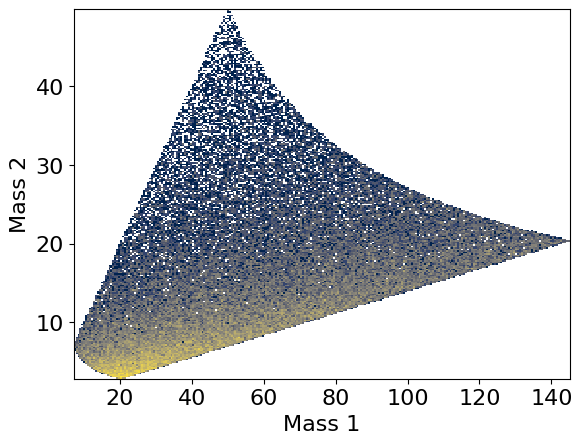

In [23]:
# Relationship between chirp mass and mass ratio
plt.hist2d(m1, m2, cmap='cividis', bins=256, norm=mpl.colors.LogNorm())
plt.xlabel('Mass 1')
plt.ylabel('Mass 2')
plt.show()

### Generating waveforms for optimal SNR calculation

In [105]:
PSDs = {}
psd_files = glob.glob("/local/scratch/igr/nnarenraju/dataset_D4_2e6_Nov28_seed2GW_combination/psds/*")
for psd_file in psd_files:
    with h5py.File(psd_file, 'r') as fp:
        data = np.array(fp['data'])
        delta_f = fp.attrs['delta_f']
        name = fp.attrs['name']
        
    psd_data = FrequencySeries(data, delta_f=delta_f)
    # Store PSD data into lookup dict
    PSDs[name] = psd_data


psds = [PSDs['median_det1'], PSDs['median_det2']]
psds_data = [interpolate(psd, 0.0078125) for psd in psds_data]

In [106]:
class FastGenerateWaveform():
    ## Used to augment on all parameters (uses GPU-accelerated IMRPhenomPv2 waveform generation)
    ## Link to Ripple: https://github.com/tedwards2412/ripple
    def __init__(self, sample_length=15.0):
        # Generate the frequency grid (default values)
        self.f_lower = 20.
        self.f_upper = 2048.
        self.delta_f = 0.25
        self.delta_t = 1./2048.
        self.sample_length_in_s = 1./self.delta_f
        self.f_ref = self.f_lower
        # Clean-up params
        self.rwrap = 3.0
        # Tapering params
        beta = 8
        # Condition for optimise f_min
        self.duration_padfactor = 1.1
        # Pick the longest waveform from priors to make some params static
        # Below params are for m1 = 5.01, m2 = 5.0 and with aligned spins s1z, s2z = 0.99
        _theta = {'mass1': 5.01, 'mass2': 5.0, 'spin1z': 0.99, 'spin2z': 0.99}
        self.tmp_f_lower, self.tmp_delta_f, self.fsize = self.optimise_fmin(_theta)
        # Get the fseries over which we get the waveform in FD
        self.fseries = np.arange(0.0, self.f_upper, self.tmp_delta_f)
        # self.fseries = np.arange(self.tmp_f_lower, self.f_upper, self.tmp_delta_f)
        fseries_trunc = self.fseries[:self.fsize]
        self.cshift = np.exp(-2j*np.pi*(-self.rwrap)*fseries_trunc)
        self.clean_idx = self.fseries < self.tmp_f_lower
        # Windowing params
        self.width = self.f_lower - self.tmp_f_lower
        self.winlen = int(2. * (self.width / self.tmp_delta_f))
        self.window = np.array(get_window(('kaiser', beta), self.winlen))
        self.kmin = int(self.tmp_f_lower / self.tmp_delta_f)
        self.kmax = self.kmin + self.winlen//2

        # Used for obtaining random polarisation angle
        self.uniform_angle_distr = distributions.angular.UniformAngle(uniform_angle=(0., 2.0*np.pi))
        # Used for obtaining random ra and dec
        self.skylocation_distr = distributions.sky_location.UniformSky()

        # Projection params
        self.signal_length = sample_length # seconds
        self.whiten_padding = 5.0 # seconds
        self.error_padding_in_s = 0.5 # seconds
    
    def __str__(self):
        data = "f_lower = {}, f_upper = {}, \n \
        delta_f = {}, delta_t = {}, f_ref = {}, \n \
        rwrap = {}".format(self.f_lower, self.f_upper, self.delta_f,
                                   self.delta_t, self.f_ref, self.rwrap)
        return data

    """ ONE-OFF FUNCTIONS (Dont't require JAX or to be jitted in any way) """
    def ms_to_Mc_eta(self, masses):
        ## Converts binary component masses to chirp mass and symmetric mass ratio.
        m1, m2 = masses
        return (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5), m1 * m2 / (m1 + m2) ** 2

    def get_imr_duration(self, theta, f_lower):
        # This function is applicable for IMRPhenomD and IMRPhenomPv2
        # Multiplying by a factor of 1.1 for overestimate of signal duration
        return 1.1 * lalsim.SimIMRPhenomDChirpTime(theta['mass1']*1.989e+30, theta['mass2']*1.989e+30, 
                                                   theta['spin1z'], theta['spin2z'], 
                                                   f_lower)
    
    def nearest_larger_binary_number(self, input_len):
        # Return the nearest binary number larger than input_len.
        return int(2**np.ceil(np.log2(input_len)))

    def optimise_fmin(self, theta):
        ## NOTE: We find that even for the longest duration waveform we deal with
        ## the value of f_lower is still 17.02 Hz (we can fix this value and remove this function)
        # determine the duration to use
        full_duration = duration = self.get_imr_duration(theta, self.f_lower)
        tmp_f_lower = self.f_lower
        while True:
            # This iteration is typically done 16 times
            full_duration = self.get_imr_duration(theta, tmp_f_lower)
            condition = duration * self.duration_padfactor
            if full_duration >= condition:
                break
            else:
                # We can change this to tmp_f_lower -= 3.0 to lower iterations
                # It will consequently increase the time taken for waveform generation process
                # But, we've already seen that this shouldn't matter much for Ripple
                # tmp_f_lower *= 0.99 is consistent with PyCBC docs
                tmp_f_lower *= 0.99

        # factor to ensure the vectors are all large enough. We don't need to
        # completely trust our duration estimator in this case, at a small
        # increase in computational cost
        fudge_duration = (full_duration + .1 + self.rwrap) * self.duration_padfactor
        fsamples = int(fudge_duration / self.delta_t)
        N = self.nearest_larger_binary_number(fsamples)
        fudge_duration = N * self.delta_t

        tmp_delta_f = 1.0 / fudge_duration
        tsize = int(1.0 / self.delta_t /  tmp_delta_f)
        fsize = tsize // 2 + 1

        return (tmp_f_lower, tmp_delta_f, fsize)
    
    """ NON-JITTABLES """
    # Using jnp and jitting this function caused significant slowdown
    # Might have something to do with multiple compilations
    def ripple_cleanup(self, hpol):
        # Add the 0th frequency bin back into the fseries
        hpol = np.insert(hpol, 0, 0)
        # ad-hoc high pass filtering
        hpol[self.clean_idx] = 0.0
        return hpol
    
    """ JITTABLES (JAX/JIT implementation removed in Dec 2023) """
    # Jitting these functions require the first argument (self) to be defined as static
    def convert_to_timeseries(self, hpol):
        ## Convert frequency series to time series
        return np.fft.irfft(hpol) * (1./self.delta_t)
    
    def fd_taper_left(self, out):
        # Apply Tapering
        out[self.kmin:self.kmax] = out[self.kmin:self.kmax] * self.window[:self.winlen//2]
        out[:self.kmin] = out[:self.kmin] * 0.
        # Convert frequency series to time series
        out = self.convert_to_timeseries(out)
        return out
    
    def cyclic_time_shift(self, hpol):
        return hpol * self.cshift

    def resize(self, hpol):
        # Use jnp to speed things up
        return hpol[0:self.fsize]

    def get_theta_ripple(self, theta):
        # Convert the prior values to jnp array
        # Following params are required for IMRPhenomPv2
        # m1_msun, m2_msun, s1x, s1y, s1z, s2x, s2y, s2z, distance_mpc, tc, phiRef, inclination
        Mc, eta = self.ms_to_Mc_eta(np.array([theta[0], theta[1]]))
        theta_ripple = np.append(np.array([Mc, eta]), np.array(theta[2:]))
        return theta_ripple
    
    def get_theta_pycbc(self, theta):
        # Add required params to waveform kwargs
        theta['f_lower'] = self.tmp_f_lower
        theta['delta_f'] = self.tmp_delta_f
        theta['delta_t'] = self.delta_t
        theta['f_final'] = 2048.0
        return theta
    
    def get_pycbc_hphc(self, theta):
        # Get the IMRPhenomPv2 waveform using PyCBC
        return pycbc.waveform.get_fd_waveform(**theta)

    """ MAIN """
    def make_injection(self, hp, hc, params):
        # Get the required sample length and tc
        sample_length_in_s = len(hp)/2048.
        tc_obs = sample_length_in_s - self.rwrap
        tc_req = params['tc']
        start_time = tc_obs - tc_req
        end_time = tc_obs + (self.signal_length - tc_req)
        # Pad the start and end times for whitening and error padding
        start_time -= (self.whiten_padding/2.0 + self.error_padding_in_s)
        end_time += (self.whiten_padding/2.0 + self.error_padding_in_s)
        # Pad hpol with zeros (append or prepend) if necessary
        left_pad = int(-start_time * 2048.) if start_time < 0.0 else 0
        right_pad = int((end_time-sample_length_in_s) * 2048.) if end_time > sample_length_in_s else 0
        hp = np.pad(hp, (left_pad, right_pad), 'constant', constant_values=(0.0, 0.0))
        hc = np.pad(hc, (left_pad, right_pad), 'constant', constant_values=(0.0, 0.0))
        # Slice the required section out of hpol
        start_idx = int(start_time*2048.) if start_time > 0.0 else 0
        end_idx = int(end_time*2048.) + int(left_pad)
        slice_idx = slice(start_idx, end_idx)
        hp = hp[slice_idx]
        hc = hc[slice_idx]
        return (hp, hc)

    def project(self, hp, hc, params):
        # Get hp, hc in the time domain and convert to h(t)
        # Time of coalescence
        tc = params['tc']
        tc_gps = params['injection_time']
        ## Get random value (with a given prior) for polarisation angle, ra, dec
        # Polarisation angle
        pol_angle = self.uniform_angle_distr.rvs()[0][0]
        # Right ascension, declination
        sky_pos = self.skylocation_distr.rvs()[0]
        declination, right_ascension = sky_pos
        # Use project_wave and random realisation of polarisation angle, ra, dec to obtain augmented signal
        hp = TimeSeries(hp, delta_t=self.delta_t)
        hc = TimeSeries(hc, delta_t=self.delta_t)
        # Get start interval and end interval for time series
        # Start and end interval define slice of ts without error padding
        pre_coalescence = tc + (self.whiten_padding/2.0)
        start_interval = tc_gps - pre_coalescence
        post_merger = self.signal_length - tc
        end_interval = tc_gps + post_merger + (self.whiten_padding/2.0)
        # Setting the start time for hp and hc
        hp.start_time = hc.start_time = start_interval - self.error_padding_in_s
        # Project wave and find strains for detectors
        strains = [det.project_wave(hp, hc, right_ascension, declination, pol_angle) for det in self.dets]
        time_interval = (start_interval, end_interval)
        strains = np.array([strain.time_slice(*time_interval, mode='nearest') for strain in strains])
        return strains

    def generate(self, _theta):
        theta = _theta.copy()
        ## Generate waveform on the fly using GPU-accelerated Ripple
        # Convert theta to theta_ripple (jnp) (only required params)
        theta_pycbc = self.get_theta_pycbc(theta)
        # Get h_plus and h_cross from the given waveform parameters theta
        # Note than hp and hc are in the frequency domain
        hp, hc = self.get_pycbc_hphc(theta_pycbc)
        # Resizing (to the required sample rate)
        hp = self.resize(hp)
        hc = self.resize(hc)
        # Cyclic time-shift
        hp = self.cyclic_time_shift(hp)
        hc = self.cyclic_time_shift(hc)
        # Tapering and fd_to_td
        hp_td = self.fd_taper_left(hp)
        hc_td = self.fd_taper_left(hc)

        return hp_td, hc_td
    
    def apply(self, params: dict):
        # Set lal.Detector object as global as workaround for MP methods
        # Project wave does not work with DataLoader otherwise
        detectors_abbr = ('H1', 'L1')
        detectors = [pycbc.detector.Detector(det_abbr) for det_abbr in detectors_abbr]
        setattr(self, 'dets', detectors)
        # Augmentation on all params
        hp, hc = self.generate(params)
        # Make hp, hc into proper injection (adjust to tc and zero pad)
        hp, hc = self.make_injection(hp, hc, params)
        # Convert hp, hc into h(t) using antenna pattern (H1, L1 considered)
        out = self.project(hp, hc, params)
        # Input: (h_plus, h_cross) --> output: (det1 h_t, det_2 h_t)
        return out

In [107]:
import sys
sys.path.insert(0, "../data")
from pycbc_draw_samples import read_config
ini_parent = '../data/ini_files'
dataset = 4 # MinimalOTF made specifically for dataset 4
CONFIG_PATH = "{}/ds{}.ini".format(ini_parent, dataset)
randomsampler, waveform_transforms = read_config(path=CONFIG_PATH)

In [108]:
def get_waveform_parameters(seed):
    # Draw sample using config
    # Draw samples from prior distribution.
    np.random.seed(seed)
    # Draw samples from prior distribution.
    prior = randomsampler.rvs(size=1)
    # Apply parameter transformation.
    prior = transforms.apply_transforms(prior, waveform_transforms)
    return prior

def set_waveform_parameters(params, seed):
    # Get waveform params using PyCBC ini file
    priors = get_waveform_parameters(seed=seed)
    waveform_kwargs = {}
    waveform_kwargs['approximant'] = 'IMRPhenomXPHM'
    waveform_kwargs['f_ref'] = 20.0
    waveform_kwargs.update(dict(zip(list(priors.fieldnames), priors[0])))
    # Adding only dominant modes to the waveform
    # waveform_kwargs['mode_array'] = [ [2,2], [2,-2] ]
    # Set waveform parameters for Ripple IMRPhenomPv2
    # m1_msun, m2_msun, s1x, s1y, s1z, s2x, s2y, s2z, distance_mpc, tc, phiRef, inclination
    for key in params.keys():
        params[key] = priors[key][0]
    return (waveform_kwargs, params)

In [109]:
foo = FastGenerateWaveform(sample_length=12.0)
waveform_generation = foo.apply

In [157]:
def generate_data(seed, only_params=False):
    ## Generate waveform or read noise sample for D4
    # Are we generating noise or waveform?
    np.random.seed(seed)
    target = 1
    # Target can be set using probablity of hypothesis
    targets = {}
    targets['gw'] = target
    
    # Set parameters for waveform generation
    # Parameter (time of coalescence, tc) is always set to 0.0 for Ripple to reproduce LAL
    # NOTE: All further manipulations assume this. Do not change this to any other value.
    params = {'mass1': -1, 'mass2': -1, 'spin1x': -1, 'spin1y': -1, 'spin1z': -1,
              'spin2x': -1, 'spin2y': -1, 'spin2z': -1, 'distance': -1, 'tc': -1,
              'coa_phase': -1,  'inclination': -1, 'ra': -1, 'dec': -1, 'polarization': -1, 
              'chirp_distance': -1}
      
    waveform_kwargs, params = set_waveform_parameters(params.copy(), seed)
    m1, m2 = params['mass1'], params['mass2']
    mchirp = (m1*m2 / (m1+m2)**2.)**(3./5) * (m1 + m2)
    params['mchirp'] = mchirp
    params['q'] = m1/m2
    if only_params:
      return params

    ## Generate waveform sample
    sample = waveform_generation(waveform_kwargs)

    return (sample, targets, params)

In [154]:
num_samples = 1_000_000

In [139]:
def generate_snr_sample(i):
    sample, targets, params = generate_data(seed=i)
    sample = [TimeSeries(foo, delta_t=1./2048.) for foo in sample]
    # Compute network SNR, rescale to generated target network SNR and inject into noise
    network_snr = np.sqrt(sum([pycbc.filter.matchedfilter.sigmasq(strain, psd=psd, low_frequency_cutoff=15.) for strain, psd in zip(sample, psds)]))
    return network_snr

In [140]:
with multiprocessing.Pool(32) as p:
      network_snrs = list(tqdm(p.imap(generate_snr_sample, np.arange(num_samples)), total=num_samples))

100%|██████████| 1000000/1000000 [1:22:18<00:00, 202.49it/s]


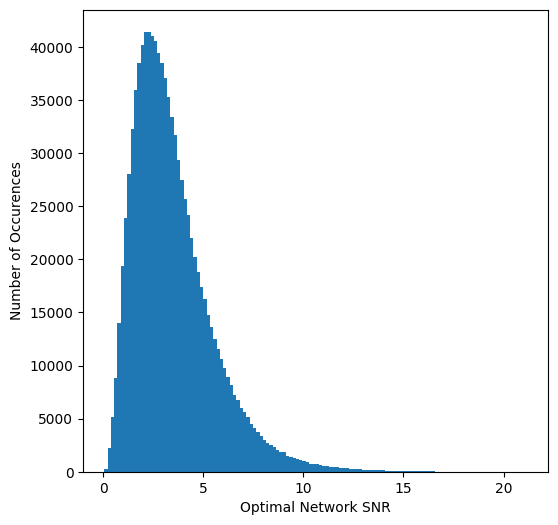

In [145]:
network_snrs = np.array(network_snrs)
network_snrs = network_snrs[network_snrs < 100]
plt.figure(figsize=(6.0, 6.0))
plt.hist(network_snrs, bins=128)
plt.xlabel('Optimal Network SNR')
plt.ylabel('Number of Occurences')
plt.show()

In [176]:
alt_names = {'mass1': 'Mass 1', 'mass2': 'Mass 2', 'spin1x': 'Spin1x', 'spin1y': 'Spin1y', 'spin1z': 'Spin1z',
            'spin2x': 'Spin2x', 'spin2y': 'Spin2y', 'spin2z': 'Spin2z', 'distance': 'Distance', 'tc': 'Time of Coalescence',
            'coa_phase': 'Coalescence Phase',  'inclination': 'Inclination', 'ra': 'Right Ascension', 'dec': 'Declination', 
            'polarization': 'Polarisation', 'chirp_distance': 'Chirp Distance', 'mchirp': 'Chirp Mass', 'q': 'Mass Ratio',
            'snr': 'Optimal Network SNR'}

In [ ]:
params = generate_data(42, only_params=True)
all_params = {key:[] for key in params.keys()}

In [174]:
def get_params(i):
    params = generate_data(i, only_params=True)
    return params

In [175]:
with multiprocessing.Pool(32) as p:
    foobar = list(tqdm(p.imap(get_params, np.arange(num_samples)), total=num_samples))

for params in foobar:
    for key in params.keys():
        all_params[key].append(params[key])

100%|██████████| 1000000/1000000 [17:36<00:00, 946.08it/s]


In [194]:
p = lambda key: all_params[key]
renamed_params = {'mass1': p('mass1'), 'mass2': p('mass2'), 'mchirp': p('mchirp'), 'q': p('q'),
                  'distance': p('distance'), 'chirp_distance': p('chirp_distance'),
                  'coa_phase': p('coa_phase'), 'inclination': p('inclination'), 'polarization': p('polarization'),
                  'ra': p('ra'), 'dec': p('dec'), 'snr': network_snrs,
                  'spin1x': p('spin1x'), 'spin1y': p('spin1y'), 'spin1z': p('spin1z'), 
                  'spin2x': p('spin2x'), 'spin2y': p('spin2y'), 'spin2z': p('spin2z')}

In [199]:
# Histogram of all prior distributions
n_bins = 128
        
ignore = []
fields = list(renamed_params.keys())
num_columns = 3
num_rows = math.ceil(len(fields)/num_columns)
fig, ax = plt.subplots(num_rows, num_columns, figsize=(7.0*num_columns, 4.0*num_rows), dpi=300)
pidxs = list(itertools.product(range(num_rows), range(num_columns)))

num_fin = 0
for n, (field, (i, j))  in enumerate(zip(fields, pidxs)):
    ax[i][j].hist(renamed_params[field], bins=n_bins, color=np.array([2, 81, 150])/255.)
    ax[i][j].set_xlabel(alt_names[field])
    if j==0:
        ax[i][j].set_ylabel('Number of Samples')
    ax[i][j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[i][j].grid()
    num_fin+=1

for i, j in pidxs[num_fin:]:
    ax[i][j].set_visible(False)

plt.tight_layout()
plt.savefig('./testing_injections.png')
plt.close()

In [207]:
np.save('./snrs.npy', network_snrs)

### Percentiles

In [202]:
snr_threshold = 10.0
snr_percentile = (len(network_snrs[network_snrs<snr_threshold])/len(network_snrs)) * 100.0
print('SNR={} is at {} percentile'.format(snr_threshold, snr_percentile))

SNR=10.0 is at 98.91149782299564 percentile


In [205]:
snr_threshold = 4.0
snr_percentile = (len(network_snrs[network_snrs<snr_threshold])/len(network_snrs)) * 100.0
print('SNR={} is at {} percentile'.format(snr_threshold, snr_percentile))

SNR=4.0 is at 68.41773683547368 percentile
